In [1]:
import requests
import pandas as pd
import datetime
import numpy as np
import xarray as xr

In [2]:
# set id used to communicate with FROST (string)
with open('/home/erlend/frost_id', 'r') as infile:
    clientID = infile.read().split()[0]

def get_available_obs_station(ids, start, end):
    start = start.strftime("%Y-%m-%dT%H:%M:%S")
    end = end.strftime("%Y-%m-%dT%H:%M:%S")
    url = "https://frost.met.no/observations/availableTimeSeries/v0.jsonld"
    reftime = f"{start}/{end}"
    headers = {"Accept": "application/json", "Authorization": f"Basic {clientID}"}
    parameters = {
        "sources": ids,
        "referencetime": reftime,
        #"fields": "sourceId, referenceTime, value, elementId",
    }
    r = requests.get(url=url, params=parameters, headers=headers, auth=(clientID, ""))
    return r.json()


def get_metadata_station(ids):
    url = "https://frost.met.no/sources/v0.jsonld"
    headers = {"Accept": "application/json", "Authorization": f"Basic {clientID}"}
    params = {
        "types": "SensorSystem",
        "ids": ids,
    }
    r = requests.get(url, params, headers=headers, auth=(clientID, ""))
    return r.json()

def get_element_fromid(ids, start, end, element, timeresolutions = None):
    start = start.strftime("%Y-%m-%dT%H:%M:%S")
    end = end.strftime("%Y-%m-%dT%H:%M:%S")
    url = "https://frost.met.no/observations/v0.jsonld"
    reftime = f"{start}/{end}"
    headers = {"Accept": "application/json"}
    parameters = {
        "sources": ids,
        "referencetime": reftime,
        "elements": element, 
        "timeoffsets": "PT0H",
        "timeresolutions":timeresolutions,
    }
        
    r = requests.get(url=url, params=parameters, headers=headers, auth=(clientID, ""))
    return r.json()

def get_available_gauges_in_area(geometry=None, elements=None, 
                                 validtime = None, country = None):
    url = "https://frost.met.no/sources/v0.jsonld"
    headers = {"Accept": "application/json", "Authorization": f"Basic {clientID}"}
    params = {
        "types": "SensorSystem",
        "geometry": geometry,
        "elements": elements,
        "validtime": validtime,
        "country": country,
    }
    r = requests.get(url, params, headers=headers, auth=(clientID, ""))
    return r.json()

In [5]:
# det station metadata:
get_metadata_station('SN17875')

{'@context': 'https://frost.met.no/schema',
 '@type': 'SourceResponse',
 'apiVersion': 'v0',
 'license': 'https://creativecommons.org/licenses/by/3.0/no/',
 'createdAt': '2023-11-03T10:11:25Z',
 'queryTime': 3.505,
 'currentItemCount': 1,
 'itemsPerPage': 1,
 'offset': 0,
 'totalItemCount': 1,
 'currentLink': 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&ids=SN17875',
 'data': [{'@type': 'SensorSystem',
   'id': 'SN17875',
   'name': 'E18 HOLSTAD',
   'shortName': 'E18 Holstad',
   'country': 'Norge',
   'countryCode': 'NO',
   'geometry': {'@type': 'Point',
    'coordinates': [10.8312, 59.685],
    'nearest': False},
   'masl': 91,
   'validFrom': '2011-07-06T00:00:00.000Z',
   'county': 'VIKEN',
   'countyId': 30,
   'municipality': 'ÅS',
   'municipalityId': 3021,
   'stationHolders': ['STATENS VEGVESEN'],
   'externalIds': ['118', '229001'],
   'wigosId': '0-578-0-17875'}]}

In [4]:
# Get available observations for station
date_start = '2021-12-01'
date_end = '2022-01-01'
start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
end = datetime.datetime.strptime(date_end, '%Y-%m-%d')
get_available_obs_station('SN17850', start, end)

{'@context': 'https://frost.met.no/schema',
 '@type': 'ObservationTimeSeriesResponse',
 'apiVersion': 'v0',
 'license': 'https://creativecommons.org/licenses/by/3.0/no/',
 'createdAt': '2023-11-03T10:09:18Z',
 'queryTime': 0.378,
 'currentItemCount': 165,
 'itemsPerPage': 165,
 'offset': 0,
 'totalItemCount': 165,
 'currentLink': 'https://frost.met.no//observations/availableTimeSeries/v0.jsonld?sources=SN17850&referencetime=2021-12-01T00%3A00%3A00%2F2022-01-01T00%3A00%3A00',
 'data': [{'sourceId': 'SN17850:0',
   'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 2},
   'validFrom': '2015-09-21T00:00:00.000Z',
   'timeOffset': 'PT0H',
   'timeResolution': 'P1M',
   'timeSeriesId': 0,
   'elementId': 'integral_of_excess(mean(air_temperature P1D) P1M 5.0)',
   'unit': 'degree-day',
   'performanceCategory': 'C',
   'exposureCategory': '1',
   'status': 'Authoritative',
   'uri': 'https://frost.met.no/observations/v0.jsonld?sources=SN17850:0&referencetime=2015-09-21T00:00

In [7]:
# get timseries from FROST, if data is available
start = date_start
end = date_end

elements = ['over_time(precipitation_type_road PT10M)']
disdrometer_names = ['SN17875'] # can be extended to several stations
start = datetime.datetime.strptime(start, '%Y-%m-%d')
end = datetime.datetime.strptime(end, '%Y-%m-%d')

stations_data = []
for station_id in disdrometer_names:
    r = get_element_fromid(
        station_id, 
        start, 
        end, 
        elements, 
        timeresolutions = 'PT10M'
    )
    
    if 'error' not in r: # checks complete timeserie for element
        data = []
        time = []
        for j in r['data']:
            data.append(j['observations'][0]['value'])
            time.append( j['referenceTime'] )
        data = np.array(data)
        time = np.array([datetime.datetime.strptime(
            i, '%Y-%m-%dT%H:%M:%S.000Z') for i in time])

        da = xr.DataArray(
            data = data.reshape(1, -1),
            coords={
                'time':time,
                'id':[station_id],
                'element':elements[0], 
                'performanceCategory': r['data'][0]['observations'][0]['performanceCategory'],
                'exposureCategory': r['data'][0]['observations'][0]['exposureCategory']
            },
            dims = ['id', 'time'],
            name = station_id,
            )
        stations_data.append(da)



In [8]:
ds_points = xr.combine_nested(stations_data, concat_dim='id').rename('type_PT10M')
# remove raingauges with only zeros (expected to be an error or not so interesting data)
idxs = []
for i in range(ds_points.id.size):
    val = ds_points.isel(id = i).values
    val = (val == 0) + np.isnan(val) # zero or nan
    if not val.all(): # keep these
        idxs.append(i)

ds_points = ds_points.isel(id = np.array(idxs)).to_dataset()

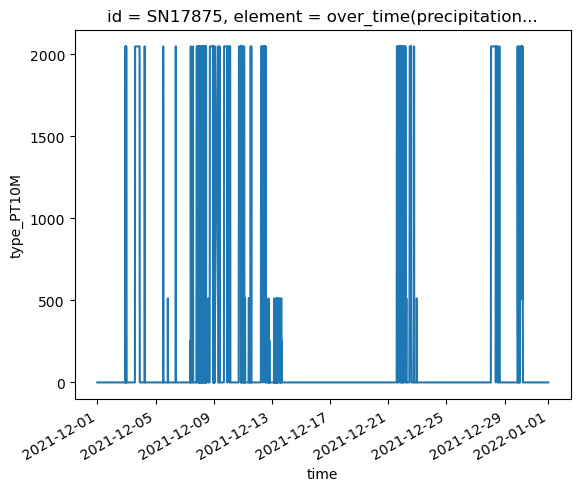

In [12]:
ds_points.isel(id = 0).type_PT10M.plot()

# download metadata and availability for several stations: 


In [ ]:
country = 'Norge' # set to none to include ie sweden
elements = 'over_time(precipitation_type_road PT10M)'  # this shuld be disdrometers


start = date_winter_start
end = date_winter_end


if (start is not None) and (end is not None):
    validtime = f"{start}/{end}"
elif (end is None) and (start is not None):
    validtime = f"{start}"
else: # all times included
    validtime = None



s = get_available_gauges_in_area(geometry=None, 
                                 elements = elements,
                                 validtime = validtime,
                                 country = country,
                                 )


start = datetime.datetime.strptime(start, '%Y-%m-%d')
end = datetime.datetime.strptime(end, '%Y-%m-%d')


stations_data = []
for station in s['data']:
    if 'STATENS VEGVESEN' in station['stationHolders']:
        # check if valid_from is ok
        if datetime.datetime.strptime(station['validFrom'], '%Y-%m-%dT%H:%M:%S.%fZ') < start:
            lon = station['geometry']['coordinates'][0]
            lat = station['geometry']['coordinates'][1]
            da = xr.DataArray(
                coords={
                    'id':[station['id']],
                    'name':("id", [station['name'] + '_june']),
                    'resolution':("id", [str(elements)]),
                    'lat':("id", [station['geometry']['coordinates'][1]]),
                    'lon':("id", [station['geometry']['coordinates'][0]]),

                },
                dims = ['id', 'time'],
                name = station['id'],
                )
            stations_data.append(da)

